In [1]:
from IPython.display import Image
from IPython.display import display_html
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd


# UCI Default of Credit Card Clients Machine Learning

### Following analysis investigate classification problem on default of credit card client data set in Taiwan.

https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients


### Data consist of basic information on individual and their credit activity between April to September, 2005, such as Bill statement and payment state. Our aim is to predict risk of default by calculating probability of default. But without actual probability present in reality, we just examine accuracy of prediction. Data is distributed with excel format and there is no missing values.

In [2]:
df_original = pd.read_excel("./input/default of credit card clients.xls",header=1)
df_original.head()


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


### Following are information on features of data set

In [3]:
print(df_original.columns)
print('\n')
for column in [ 'SEX', 'EDUCATION', 'MARRIAGE']:
    print(df_original[column].value_counts())

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')


2    18112
1    11888
Name: SEX, dtype: int64
2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64
2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64


### We rename few of columns as follows for consistency and to reduce confusion:

previous column name >>> renamed column name

PAY_0 >>> PAY_1

default payment next month >>> default

BILL_AMTi >>> BILL_AMT_i

PAY_AMTi >>> PAY_AMT_i

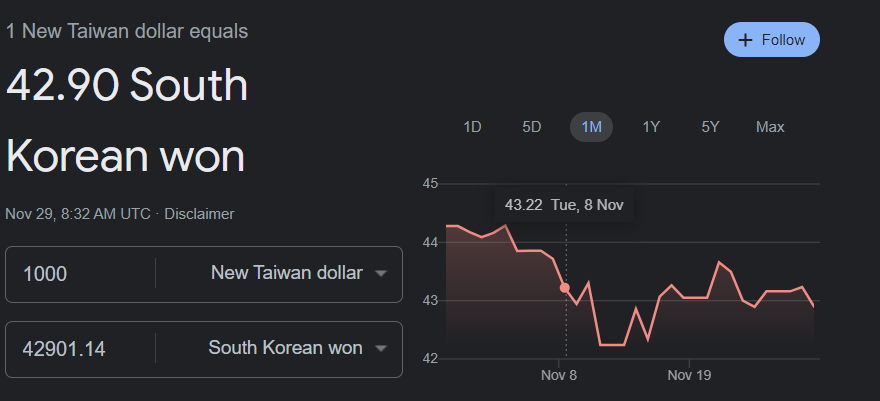

In [4]:
Image(filename='./img/1129/NT_Dollar.png')

## DATA
### This is interpretation of data aided with correction cleared by kaggle user's contact with the data provider

(https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset/discussion/34608)


### There are 30000 samples with 24 attributes, which are integer, real. 

LIMIT_BAL = Balance limit

SEX = 1 = male ; 2= femate

Education (1 = graduate school; 2 = university; 3 = high school; 0,4,5,6 = others ).

Marital status (1 = married; 2 = single; 3 = divorced ; 0 = others).

Age (year)

PAY_i :( X6 - X11): History of past payment X6 being most recent

-2 No consumption ; -1 paid duly ; 0 = The use of revolving credit ; 0< n = delayed for n-month ; 9 = payment delay for nine months and above

BILL_AMT i : Billing for ith past month (NT dollar) BILL_AMT 1 = Bill statement in September, 2005

PAY_AMT i : Payment for bill statement: BILL_AMT_(i+1)



There is no missing data

In [5]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

## Split
#### To avoid bias, we've decided to take 20 percent of data away from analysis until we are ready to make a final test. To make a fair split, we used stratifiedshuffle on SEX and default to keep the ratio close to real situation and situation data provided.

```python
split = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
for train_index , test_index in split.split(df,df.iloc[:,[2,-1]]):
    df_train = df.loc[train_index]
    df_test = df.loc[test_index]
```

In [6]:
from data_loader_default import load_data_default

load_data = load_data_default()

X,y = load_data.load_train_data()
df = pd.concat([X,y],axis=1)

## New Attributes:

### DIFF_i (i=1~5), USAGE_i (i=1~5)

### DIFF_i

= Difference between bill statement and paid amount

= BILL_AMT_i - PAY_i-1

### USAGE_i 

= Usage approximation by subtraction of unpaid amount on previous month from bill statement in corresponding month

= BILL_AMT_i - (BILL_AMT i+1-PAY_i)


## Logarithmic transformation

For our data handles capital attributes, we tried logarithmic transformation, trying to reshape data in to normal distribution. But for capital attributes sometimes holds negative values such as over paying, we modified logarithmic transform before using.

Since data had (positive and negative) integer values, it does not have value between 0 and 1. 

$$ L(x) = log(1+2|x|)sign(x)$$

This guarantees logarithmic mapping of both positive side and negative side, preserving the meaning of 0.


## Comparison with non log scale


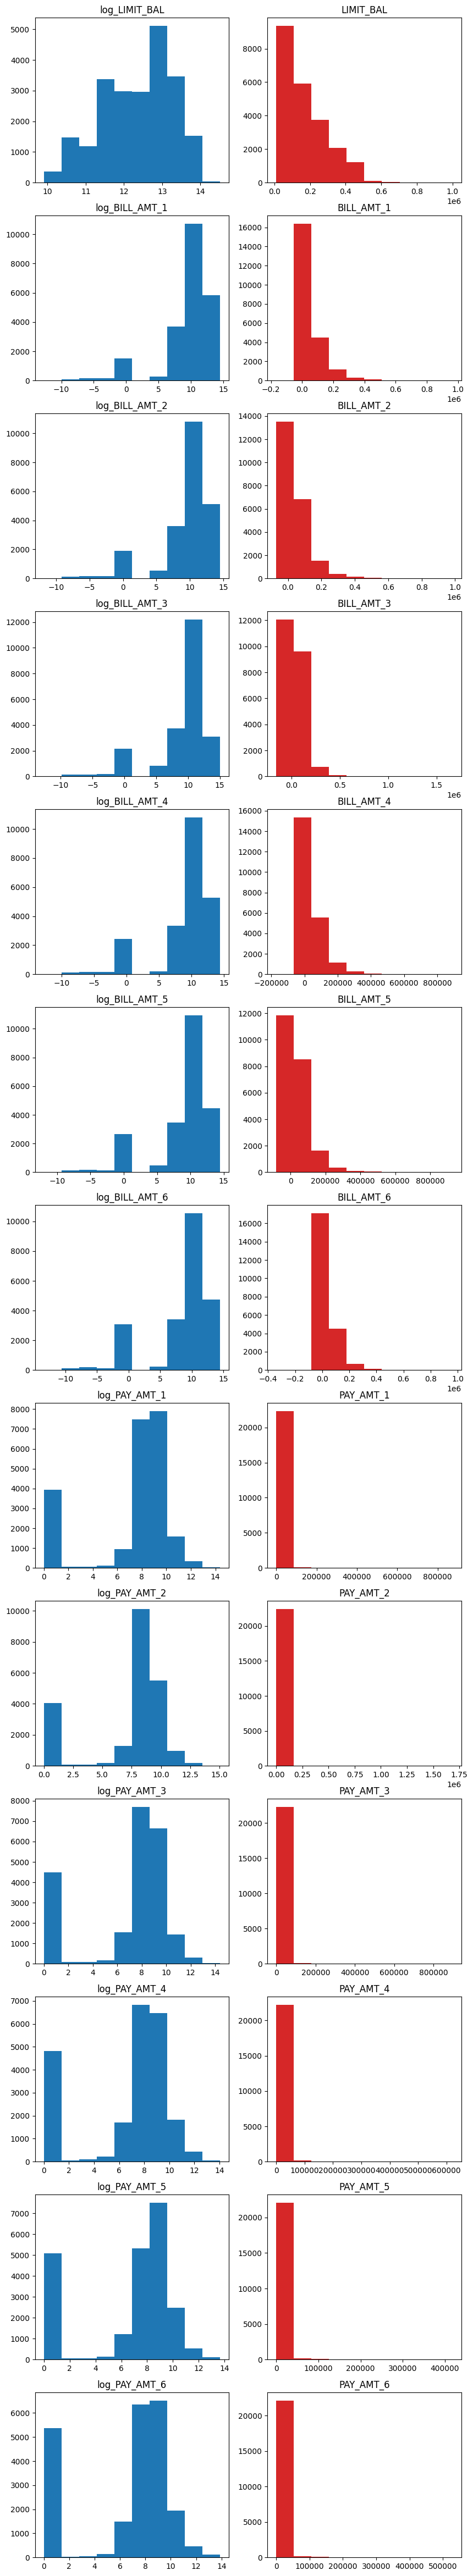

In [7]:
from mods_defaults import BasicTransformer
my_basic = BasicTransformer()
df_log = my_basic.transform(df)
Cols =['LIMIT_BAL',
       'BILL_AMT_1', 'BILL_AMT_2','BILL_AMT_3', 'BILL_AMT_4', 'BILL_AMT_5', 'BILL_AMT_6', 
       'PAY_AMT_1','PAY_AMT_2', 'PAY_AMT_3', 'PAY_AMT_4', 'PAY_AMT_5', 'PAY_AMT_6']

n = len(Cols)
fig, axes = plt.subplots(n,2, num=1, clear=True, figsize=(10,60))

for i,column in enumerate(Cols):
    axes[i,0].hist(df_log[f'log_{column}'],color='C0')
    axes[i,0].set_title(f'log_{column}')
for k,col_name in enumerate(Cols):
    axes[k,1].hist(df[col_name],color='C3')
    axes[k,1].set_title(col_name)
plt.show()
plt.close()

It is yet to be close with normal distribution but we will use this transformation considering capital character of attributes.



## Time Series Analysis

Chronological order is essence in our monthly data. e.g) PAY_i and PAY_AMT_i 

Hence we've tried time series analysis to catch pattern of samples.

While explaining modules we used for time series, we will explain all other modules we made.

## Modules


### ElementaryExtractor : 
basic time series transformer such as mean max and diff-max etc.

### BasicTransformer : 
module for added attributes (USAGE_i and DIFF_i) and log transformation.

### MyMulPyts : 
Modification of MultivariateTransformer of pyts module. Modified to determine which columns to transform. Takes list of channels where channel is list of column names in chronological order e.g) ['PAY_1', ...]

### NonTsPass : 
Pass non time series attributes. one hot encodes SEX, EDUCATION, MARRIAGE


### Passer : 
Passes columns with input of column list

### AllPerturb, PositivePerturb : 
Data augmentation module


## Evaluation

### Considering our background I decided to concentrate on accuracy and recall
### Decided to use 5 fold CV on StratifiedKFold, which will save ratio between defaults and non defaults

```python
class load_data_default ():
...
...
        self.StratifiedKFold =StratifiedKFold(n_splits=5,shuffle=True,random_state = 42)

    def split(self):
        '''
        Yields StratifiedKFold's split with fixed data, parameter
        X= non test data frame i.e. self.df_train
        y= SEX and default of non test data
        n_split = 5
        shuffle True
        random state =42
        '''
        return self.StratifiedKFold.split(self.df_train,self.label_train)
    def yield_data(self):
        '''
        Yield tuple (X_train, y_train, X_val, y_val) of StratifiedKFold.split with fixed data and parameter
        '''
        for train_index , test_index in self.split():
            X_train, y_train= self.df_train.iloc[train_index],self.label_train.iloc[train_index]
            X_val, y_val= self.df_train.iloc[test_index], self.label_train.iloc[test_index]       
            yield X_train,y_train,X_val,y_val

```

In [8]:
(12772+799)/(10782 + 2360 + 2408 +1325)

0.8042074074074074

In [9]:
(12509+1339)/(10782 + 2360 + 2408 +1325)

0.8206222222222223

## Classifiers

### Linear regression, SVM, Tree type Ensemble

Linear regression type showed 80-81 accuracy

SVM showed 80-82 accuracy with recall around 30-35, less accuracy for high recall


### Tree types

,clf,acc,prec,rec,f1,roc_auc
0,lgbm_t_series,0.824000,0.722100,0.331700,0.454500,0.776900
1,lgbm_t_series,0.818000,0.697300,0.312600,0.431600,0.768100
2,lgbm_t_series,0.818400,0.696000,0.317600,0.436200,0.780100
3,lgbm_t_series,0.820000,0.696200,0.331300,0.449000,0.769200
4,lgbm_t_series,0.827300,0.726700,0.352400,0.474600,0.797400


,clf,acc,prec,rec,f1,roc_auc
0,ADA_t_series,0.823600,0.728900,0.321600,0.446300,0.754800
1,ADA_t_series,0.818700,0.696700,0.318600,0.437200,0.753200
2,ADA_t_series,0.818200,0.698900,0.312600,0.431900,0.750000
3,ADA_t_series,0.818200,0.680900,0.336300,0.450300,0.760700
4,ADA_t_series,0.825800,0.722700,0.345400,0.467400,0.783100


,clf,acc,prec,rec,f1,roc_auc
0,rf_t_series,0.822000,0.683000,0.363800,0.474800,0.778600
1,rf_t_series,0.816000,0.664700,0.338700,0.448700,0.771600
2,rf_t_series,0.810000,0.646400,0.310600,0.419600,0.779200
3,rf_t_series,0.819300,0.666700,0.367500,0.473800,0.769300
4,rf_t_series,0.824700,0.702500,0.360400,0.476400,0.799300


Text(0.5, 0.98, 'Confusion matrix of lgbm_t_series')

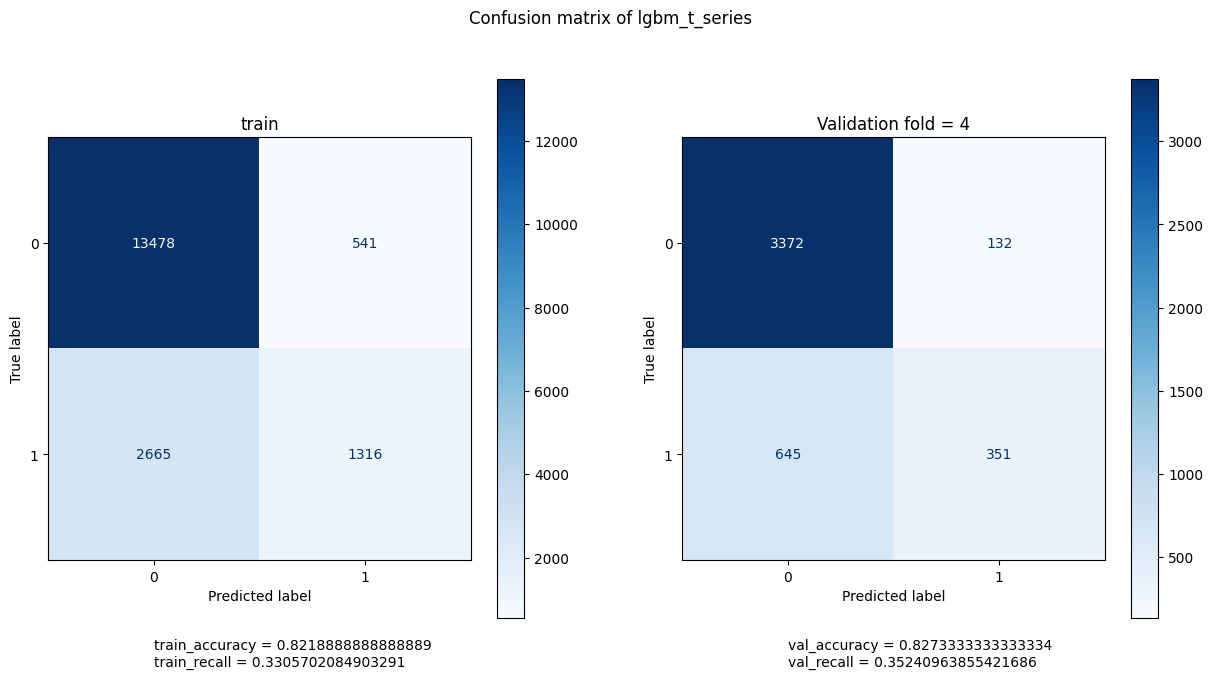

In [10]:
from IPython.display import display_html
clfs = ['DA_lgbm_t_series', 'DA_ADA_t_series', 'DA_rf_t_series', 'DA_gboost_t_series']
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay,RocCurveDisplay
from sklearn.metrics import precision_score, recall_score,f1_score, accuracy_score,roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from data_loader_default import load_data_default


def my_score(y_train,y_pred):
    accuracy = accuracy_score(y_train,y_pred)
    pre_score = precision_score(y_train,y_pred)
    rec_score = recall_score(y_train,y_pred)
    f_score = f1_score(y_train,y_pred)

    return [round(accuracy,4), round(pre_score,4), round(rec_score ,4), round(f_score,4)]




X_train,y_train,X_val,y_val = 0,0,0,0
load_data = load_data_default()
DA_score_df_by_clf = []
for clf in clfs:
    if 'gboost' not in clf:
        output_path = f'./output/{clf}/'
        score_dataframes = []
        for num,(X_train ,y_train, X_val, y_val) in enumerate(load_data.yield_data()):
            pred_val = pd.read_csv(output_path+'/aug_3/'+str(num)+'/pred_val.csv',index_col=0)
            score_val = pd.read_csv(output_path+'/aug_3/'+str(num)+'/score_val.csv',index_col=0)
            scores =pd.Series([clf]+my_score(y_val,pred_val)+[round(roc_auc_score(y_val,score_val),4)]
                                ,index=['clf','acc','prec','rec','f1','roc_auc'])
            score_dataframes.append(scores)

        evals_frame = pd.concat(score_dataframes, axis=1).transpose()
        DA_score_df_by_clf.append(evals_frame)
NDA_score_df_by_clf = []
best = (0,0,0)
for clf in clfs:
    if 'gboost' not in clf:
        output_path = f'./output/{clf}/'
        score_dataframes = []
        for num,(X_train ,y_train, X_val, y_val) in enumerate(load_data.yield_data()):
            pred_train = pd.read_csv(output_path+'/non_aug/'+str(num)+'/pred_train.csv',index_col=0)
            pred_val = pd.read_csv(output_path+'/non_aug/'+str(num)+'/pred_val.csv',index_col=0)
            score_val = pd.read_csv(output_path+'/non_aug/'+str(num)+'/score_val.csv',index_col=0)
            scores =pd.Series([clf[3:]]+my_score(y_val,pred_val)+[round(roc_auc_score(y_val,score_val),4)]
                                ,index=['clf','acc','prec','rec','f1','roc_auc'])
            score_dataframes.append(scores)
            acc = accuracy_score(y_val,pred_val)
            if best[2]<acc:
                best = [clf,num,acc,pred_val,score_val,y_val,y_train,pred_train]
        evals_frame = pd.concat(score_dataframes, axis=1).transpose()
        NDA_score_df_by_clf.append(evals_frame)


best = dict(zip(['clf','num','acc','pred_val','score_val','y_val','y_train','pred_train'],best))

for i in range(3):
    df2 = NDA_score_df_by_clf[i]
    df2_styler = df2.style.set_table_attributes("style='display:inline'").set_caption('Original')
    display_html(df2_styler._repr_html_(), raw=True)
    print('\n\n\n')

cf_matrix_t = confusion_matrix(best['y_train'],best['pred_train'])
cf_matrix_v = confusion_matrix(best['y_val'],best['pred_val'])
fig,axes = plt.subplots(1,2,figsize=(15,7))
display = ConfusionMatrixDisplay(cf_matrix_t)
display.plot(cmap=plt.cm.Blues,ax=axes[0])
axes[0].set_title("train")
train_acc = accuracy_score(best['y_train'],best['pred_train'])
train_rec = recall_score(best['y_train'],best['pred_train'])
axes[0].text(0,2,f'train_accuracy = {train_acc}\ntrain_recall = {train_rec}')
display = ConfusionMatrixDisplay(cf_matrix_v)
display.plot(cmap=plt.cm.Blues,ax=axes[1])
axes[1].set_title(f"Validation fold = {best['num']}")
val_acc =accuracy_score(best['y_val'],best['pred_val'])
val_rec = recall_score(best['y_val'],best['pred_val'])
axes[1].text(0,2,f'val_accuracy = {val_acc}\nval_recall = {val_rec}')
name_best = best['clf'][3:]
fig.suptitle(f'Confusion matrix of {name_best}')


## Mighty Wall of Accuracy 83

### Most of classifier couldn't reach accuracy over 82. Despite of trying 6 data transformation; whether on log or non log, time series or raw data, for tuned hyper parameter or non tuned hyper parameter, there were no difference. 
### We even tried to fit classifier with only PAY_i's. It did not change significantly. Having various tries, we tried examined samples that are consistently incorrectly predicted.

Total 24 classifying was executed
Following are analysis of consistently wrong samples
Total number of samples =5625


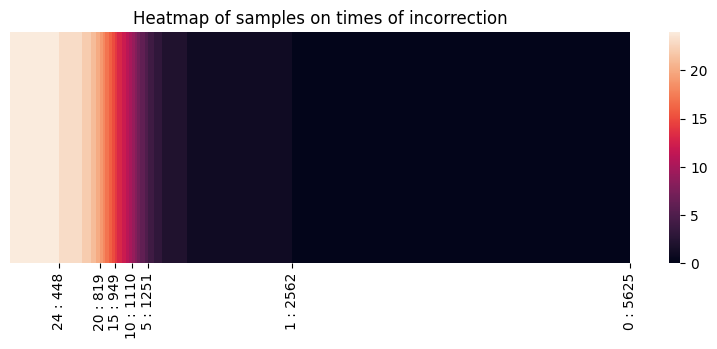

In [11]:
prediction_dataframe = pd.read_csv('./output/tree_1/val_results_less_features.csv',index_col=0)
wrong =prediction_dataframe.apply(lambda x :abs(x-prediction_dataframe.default), axis=0)
wrong_sum =wrong.sum(axis=1)



n = wrong.shape[1]-1
print(f'Total {n} classifying was executed\nFollowing are analysis of consistently wrong samples')
print(f'Total number of samples ={wrong_sum.shape[0]}')
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,3))
freq_for_heat =wrong_sum.sort_values(ascending=False).to_numpy().reshape(1,-1)
sns.heatmap(freq_for_heat,vmax=n)
x_ticks =[wrong_sum[wrong_sum>j].shape[0] for j in [n-1,19,14,9,4,0,-1]]
ax.set_xticks(x_ticks)
ax.set_xticklabels([f'{freq} : {count}' for count,freq in zip(x_ticks,[n,20,15,10,5,1,0])])
ax.set_yticks([])
ax.set_title('Heatmap of samples on times of incorrection')
plt.show()
plt.close()

## We see almost 1000 samples are consistently guessed wrong


949 samples had 14 or more incorrect answers
Default mean of samples with 14 or more incorrect answer is 0.8388
While samples with any incorrect answer had mean of 0.4372


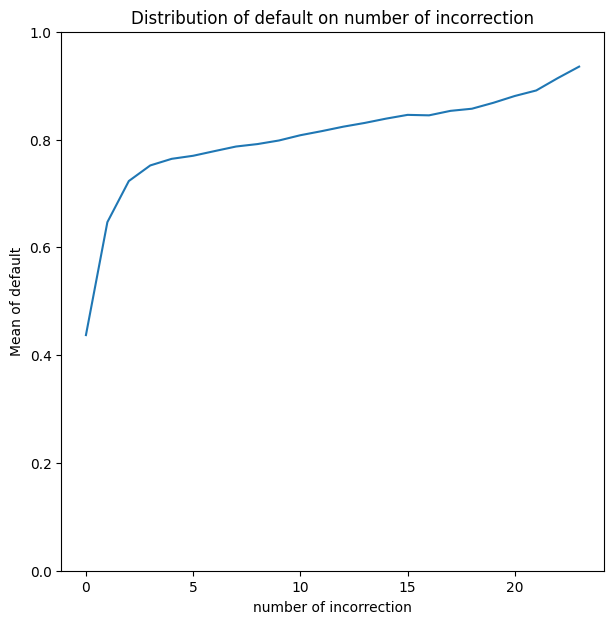

In [12]:
cons_wrong_idc =wrong_sum[wrong_sum>14].index
cons_wrong =df.loc[cons_wrong_idc]
print(f'{cons_wrong.shape[0]} samples had 14 or more incorrect answers')
print(f'Default mean of samples with 14 or more incorrect answer is {round(cons_wrong.default.mean(),4)}')
print(f'While samples with any incorrect answer had mean of {round(df.loc[wrong_sum[wrong_sum>0].index].default.mean(),4)}')
incorrect_means = [df.loc[wrong_sum[wrong_sum>i].index].default.mean() for i in np.arange(0,28)]
fig ,ax = plt.subplots(figsize=(7,7))
ax.plot(np.arange(0,28),incorrect_means)
ax.set_ylim(0,1)
ax.set_ylabel('Mean of default')
ax.set_xlabel('number of incorrection')
ax.set_title('Distribution of default on number of incorrection')
plt.show()
plt.close()

In [13]:
print(f'Note that this analysis was on validation set given by stratified split on train set, having {wrong_sum.shape[0]} samples,')
print(f'with {prediction_dataframe.loc[prediction_dataframe.default==0].shape[0]} non-default samples')
print(f'and {prediction_dataframe.loc[prediction_dataframe.default==1].shape[0]} default samples')
print(f'Among 949 consistently wrong samples, we had 80 percent of default samples. Thus, among 1244 default samples, {int(949*0.838)} are consistently incorrectly guessed')

Note that this analysis was on validation set given by stratified split on train set, having 5625 samples,
with 4381 non-default samples
and 1244 default samples
Among 949 consistently wrong samples, we had 80 percent of default samples. Thus, among 1244 default samples, 795 are consistently incorrectly guessed


### Figure shows that consistently wrong samples are mostly default and more than half of defaults were consistently incorrect

## Data Augmentation

### By previous analysis, sample with defaults were poorly guessed. Considering shortage on samples with default (22 percent) we tried data augmentation on sample with default.

```python
class PositivePerturb():
    def __init__(self, random_state=None,dup_num=1):
        self.random_state = random_state
        self.dup_num = dup_num
    def fit(self, X, y):
        return self
    
    def transform(self, X, y):
        BILL = load_data.BILL.copy()
        BILL.pop(0)
        PAY = load_data.PAY.copy()
        PAY.pop(-1)
        rng = np.random.default_rng(self.random_state)
        X_transform = X.copy()
        y_transform = y.copy()
        for i in range(self.dup_num):
            X_aug, y_aug = X.loc[y==1].copy(), y.loc[y==1].copy()
            X_aug[BILL] *= (0.9 + 0.2*rng.random(X_aug[BILL].shape))
            X_aug[BILL] = X_aug[BILL].astype('int')
            X_aug['ID'] += 30000*(i+1)+1
            y_aug.index += 30000*(i+1)+1
            pay_perturb=(X_aug[BILL]-X.loc[y==1][BILL]).to_numpy()
            X_aug[PAY] += pay_perturb
            X_transform = pd.concat([X_transform, X_aug], axis=0, ignore_index=True)
            y_transform = pd.concat([y_transform, y_aug], axis=0, ignore_index=False)
        return X_transform,y_transform
```

Word 'positive' refers to default sample (labeled as 1).
Augmented samples are perturbed on bill statement. And by relation of PAY_AMT and BILL , we modified PAY_AMT according to perturbation on bill statement

In [14]:

DA_score_df_by_clf = []
for clf in clfs:
    if 'gboost' not in clf:
        output_path = f'./output/{clf}/'
        score_dataframes = []
        for num,(X_train ,y_train, X_val, y_val) in enumerate(load_data.yield_data()):
            pred_val = pd.read_csv(output_path+'/aug_3/'+str(num)+'/pred_val.csv',index_col=0)
            score_val = pd.read_csv(output_path+'/aug_3/'+str(num)+'/score_val.csv',index_col=0)
            scores =pd.Series([clf[3:]]+my_score(y_val,pred_val)+[round(roc_auc_score(y_val,score_val),4)]
                                ,index=['clf','acc','prec','rec','f1','roc_auc'])
            score_dataframes.append(scores)

        evals_frame = pd.concat(score_dataframes, axis=1).transpose()
        DA_score_df_by_clf.append(evals_frame)
NDA_score_df_by_clf = []
for clf in clfs:
    if 'gboost' not in clf:
        output_path = f'./output/{clf}/'
        score_dataframes = []
        for num,(X_train ,y_train, X_val, y_val) in enumerate(load_data.yield_data()):
            pred_val = pd.read_csv(output_path+'/non_aug/'+str(num)+'/pred_val.csv',index_col=0)
            score_val = pd.read_csv(output_path+'/non_aug/'+str(num)+'/score_val.csv',index_col=0)
            scores =pd.Series([clf[3:]]+my_score(y_val,pred_val)+[round(roc_auc_score(y_val,score_val),4)]
                                ,index=['clf','acc','prec','rec','f1','roc_auc'])
            score_dataframes.append(scores)

        evals_frame = pd.concat(score_dataframes, axis=1).transpose()
        NDA_score_df_by_clf.append(evals_frame)
for i in range(3):
    df1 = DA_score_df_by_clf[i]
    df2 = NDA_score_df_by_clf[i]
    df1_styler = df1.style.set_table_attributes("style='display:inline'").set_caption('Data Augmented')
    df2_styler = df2.style.set_table_attributes("style='display:inline'").set_caption('Original')
    display_html(df1_styler._repr_html_()+'\xa0'*8+df2_styler._repr_html_(), raw=True)
    print('\n\n\n')

,clf,acc,prec,rec,f1,roc_auc
0,lgbm_t_series,0.793100,0.537100,0.465300,0.498700,0.750600
1,lgbm_t_series,0.791300,0.532600,0.459300,0.493300,0.744100
2,lgbm_t_series,0.794400,0.542500,0.449200,0.491500,0.751000
3,lgbm_t_series,0.787300,0.521400,0.477900,0.498700,0.745000
4,lgbm_t_series,0.804900,0.571800,0.471900,0.517100,0.769900
,clf,acc,prec,rec,f1,roc_auc
0,lgbm_t_series,0.824000,0.722100,0.331700,0.454500,0.776900
1,lgbm_t_series,0.818000,0.697300,0.312600,0.431600,0.768100
2,lgbm_t_series,0.818400,0.696000,0.317600,0.436200,0.780100
3,lgbm_t_series,0.820000,0.696200,0.331300,0.449000,0.769200


,clf,acc,prec,rec,f1,roc_auc
0,ADA_t_series,0.782900,0.508900,0.518600,0.513700,0.749100
1,ADA_t_series,0.792400,0.537200,0.442200,0.485100,0.743700
2,ADA_t_series,0.780000,0.502600,0.486400,0.494400,0.745100
3,ADA_t_series,0.779800,0.502400,0.522100,0.512100,0.747500
4,ADA_t_series,0.800900,0.562200,0.453800,0.502200,0.766600
,clf,acc,prec,rec,f1,roc_auc
0,ADA_t_series,0.823600,0.728900,0.321600,0.446300,0.754800
1,ADA_t_series,0.818700,0.696700,0.318600,0.437200,0.753200
2,ADA_t_series,0.818200,0.698900,0.312600,0.431900,0.750000
3,ADA_t_series,0.818200,0.680900,0.336300,0.450300,0.760700


,clf,acc,prec,rec,f1,roc_auc
0,rf_t_series,0.796000,0.539900,0.523600,0.531600,0.755900
1,rf_t_series,0.794400,0.538100,0.496500,0.516500,0.751600
2,rf_t_series,0.794000,0.538100,0.482400,0.508700,0.755900
3,rf_t_series,0.785600,0.515700,0.510000,0.512900,0.748600
4,rf_t_series,0.806200,0.566700,0.529100,0.547200,0.773800
,clf,acc,prec,rec,f1,roc_auc
0,rf_t_series,0.822000,0.683000,0.363800,0.474800,0.778600
1,rf_t_series,0.816000,0.664700,0.338700,0.448700,0.771600
2,rf_t_series,0.810000,0.646400,0.310600,0.419600,0.779200
3,rf_t_series,0.819300,0.666700,0.367500,0.473800,0.769300


### We see there is increase on recall but decrease on accuracy

In [15]:
clf_names =pd.concat(DA_score_df_by_clf,axis=0).clf
DA_acc_rec =pd.concat(DA_score_df_by_clf,axis=0)[['acc','rec']]
NDA_acc_rec =pd.concat(NDA_score_df_by_clf,axis=0)[['acc','rec']]
pd.concat( [clf_names,(DA_acc_rec-NDA_acc_rec)*100] , axis=1)

,clf,acc,rec
0,lgbm_t_series,-3.09,13.36
1,lgbm_t_series,-2.67,14.67
2,lgbm_t_series,-2.4,13.16
3,lgbm_t_series,-3.27,14.66
4,lgbm_t_series,-2.24,11.95
0,ADA_t_series,-4.07,19.7
1,ADA_t_series,-2.63,12.36
2,ADA_t_series,-3.82,17.38
3,ADA_t_series,-3.84,18.58
4,ADA_t_series,-2.49,10.84


## Still having low recall; around 50, this might not have much meaning. But at least we can check it does have effect on recall

## Back to EDA: Bad Samples

### Sample ID =3333

In [16]:
my_basic = BasicTransformer('')
df_full = pd.concat([
                    df[['ID','default']],
                    my_basic.transform(df)],axis=1) 

df_full.loc[df.ID==3333].transpose()

,3332
ID,3333
default,1
LIMIT_BAL,500000
SEX,1
EDUCATION,1
MARRIAGE,1
AGE,59
PAY_1,-2
PAY_2,-2
PAY_3,-2


## Despite having zero debt, this samples is labeled as default

### Not only sample ID =3333, there were plenty of strange samples. We've tried to find more strange samples by filtering with certain criterion. 

### For PAY_1 is debt status of previous month, we've checked samples with PAY_1 = -2 and default positive.



In [17]:
i,_ = df.loc[ (df.PAY_1==-2) & (df.default==1)].shape
print(f'PAY_1 =-2 & positive :{i}')
print(f'While we have total {df.loc[df.default==1].shape[0]} positive samples. It is about 6 percent')

PAY_1 =-2 & positive :282
While we have total 4977 positive samples. It is about 6 percent


### Also, 1000 NT dollars are not really big amount

In [18]:
i,_ = df.loc[ (df.BILL_AMT_1<1000)& (df.default==1)].shape
print(f'{i} samples were marked default with debt less than 1000 NT dollars')

875 samples were marked default with debt less than 1000 NT dollars


### Low Billstatement and duly paid status is evidence of non default and almost contradictory. Thus we tried to exclude those samples.

In [19]:
i,_=df.loc[(df.BILL_AMT_1<1000) & (df.default==1)].shape
print(f'Less than 1000 :{i}')
i,_ =df.loc[
            ((df.BILL_AMT_1<1000) & (df.default==1)) &
            ((df.PAY_1==-2) & (df.default==1))].shape
print(f'Less than 1000 and -2 :{i}')
i,_ = df.loc[ (df.PAY_1==-2) & (df.default==1)].shape
print(f'-2 :{i}')
i,_ =df.loc[
            ((df.BILL_AMT_1<1000) & (df.default==1)) |
            ((df.PAY_1==-2) & (df.default==1))].shape
print(f'Less than 1000 or -2 :{i}')


Less than 1000 :875
Less than 1000 and -2 :186
-2 :282
Less than 1000 or -2 :971


### And we have repeated analysis on consistently wrong samples and while inspecting them we found other criteria for excluding: Difference between paid amount and billstatement.

### final script on data loader_exclude looks like this:
```python
            df = df.loc[
                        ((df.BILL_AMT_1>1001) | (df.default!=1)) &
                        ((df.PAY_1!=-2) | (df.default!=1)) &
                        ((df_t.DIFF_1>1501)|(df.default!=1)) ]
```

## Afterward we examined with 'strange' samples excluded. To do so, we added parameter exclude=True to data loader

In [20]:
from data_loader_exclude import load_data_default as load_data_exclude
exc_load_data = load_data_exclude(exclude=True)
exc_df = exc_load_data.df_train
_,exc_y = exc_load_data.load_train_data()
non_exc = {'Total':df.shape[0],'Defaults':df.loc[df.default==1].shape[0]}
exc = {'Total':exc_df.shape[0],'Defaults':exc_df.loc[exc_y==1].shape[0]}
non_exc['None defaults'] = non_exc['Total']-non_exc['Defaults']
exc['None defaults'] = exc['Total']-exc['Defaults']
compare_number = pd.DataFrame([non_exc,exc],index=['Original', 'Excluded'])
compare_number['Default ratio'] = compare_number.Defaults/compare_number.Total
compare_number['Non default ratio'] = compare_number['None defaults']/compare_number.Total
compare_number

,Total,Defaults,None defaults,Default ratio,Non default ratio
Original,22500,4977,17523,0.221200,0.778800
Excluded,21040,3517,17523,0.167158,0.832842


,clf,acc,prec,rec,f1,roc_auc
0,lgbm_t_series,0.867900,0.630600,0.505000,0.560800,0.867400
1,lgbm_t_series,0.871200,0.649400,0.497900,0.563600,0.877500
2,lgbm_t_series,0.875700,0.662500,0.522000,0.583900,0.887100
3,lgbm_t_series,0.861000,0.607200,0.478700,0.535300,0.856500
4,lgbm_t_series,0.872600,0.642900,0.536900,0.585100,0.870700
,clf,acc,prec,rec,f1,roc_auc
0,lgbm_t_series,0.873800,0.670000,0.482200,0.560800,0.877300
1,lgbm_t_series,0.875200,0.677300,0.483600,0.564300,0.880700
2,lgbm_t_series,0.880000,0.693400,0.505000,0.584400,0.889100
3,lgbm_t_series,0.868300,0.643700,0.477300,0.548100,0.866900


,clf,acc,prec,rec,f1,roc_auc
0,ADA_t_series,0.872100,0.687900,0.429600,0.528900,0.864700
1,ADA_t_series,0.873300,0.698600,0.425300,0.528700,0.865900
2,ADA_t_series,0.878800,0.717800,0.452300,0.555000,0.882700
3,ADA_t_series,0.865500,0.662000,0.400600,0.499100,0.846300
4,ADA_t_series,0.882100,0.734200,0.463100,0.567900,0.861800
,clf,acc,prec,rec,f1,roc_auc
0,ADA_t_series,0.877600,0.743500,0.408300,0.527100,0.876400
1,ADA_t_series,0.872100,0.704700,0.404000,0.513600,0.873000
2,ADA_t_series,0.880200,0.745700,0.429600,0.545100,0.884600
3,ADA_t_series,0.866200,0.674100,0.387800,0.492300,0.859200


,clf,acc,prec,rec,f1,roc_auc
0,rf_t_series,0.871200,0.627200,0.564700,0.594300,0.868200
1,rf_t_series,0.873800,0.641400,0.554800,0.595000,0.873600
2,rf_t_series,0.875500,0.646000,0.563300,0.601800,0.884600
3,rf_t_series,0.860700,0.596100,0.519900,0.555400,0.848100
4,rf_t_series,0.871700,0.628500,0.569600,0.597600,0.866000
,clf,acc,prec,rec,f1,roc_auc
0,rf_t_series,0.876000,0.680600,0.485100,0.566400,0.880500
1,rf_t_series,0.875500,0.686800,0.468000,0.556700,0.877700
2,rf_t_series,0.878600,0.692000,0.492200,0.575200,0.888200
3,rf_t_series,0.866200,0.640200,0.457400,0.533600,0.861300


,clf,acc,prec,rec,f1,roc_auc
0,gboost_t_series,0.871000,0.646500,0.502100,0.565300,0.867900
1,gboost_t_series,0.869100,0.665200,0.435300,0.526200,0.869700
2,gboost_t_series,0.876200,0.685700,0.478000,0.563300,0.882500
3,gboost_t_series,0.864100,0.644700,0.417600,0.506900,0.845700
4,gboost_t_series,0.880900,0.700200,0.504300,0.586300,0.867200
,clf,acc,prec,rec,f1,roc_auc
0,gboost_t_series,0.878600,0.729700,0.433900,0.544200,0.883100
1,gboost_t_series,0.874300,0.700500,0.432400,0.534700,0.876300
2,gboost_t_series,0.879800,0.726400,0.449500,0.555400,0.888300
3,gboost_t_series,0.867200,0.661500,0.421900,0.515200,0.860400


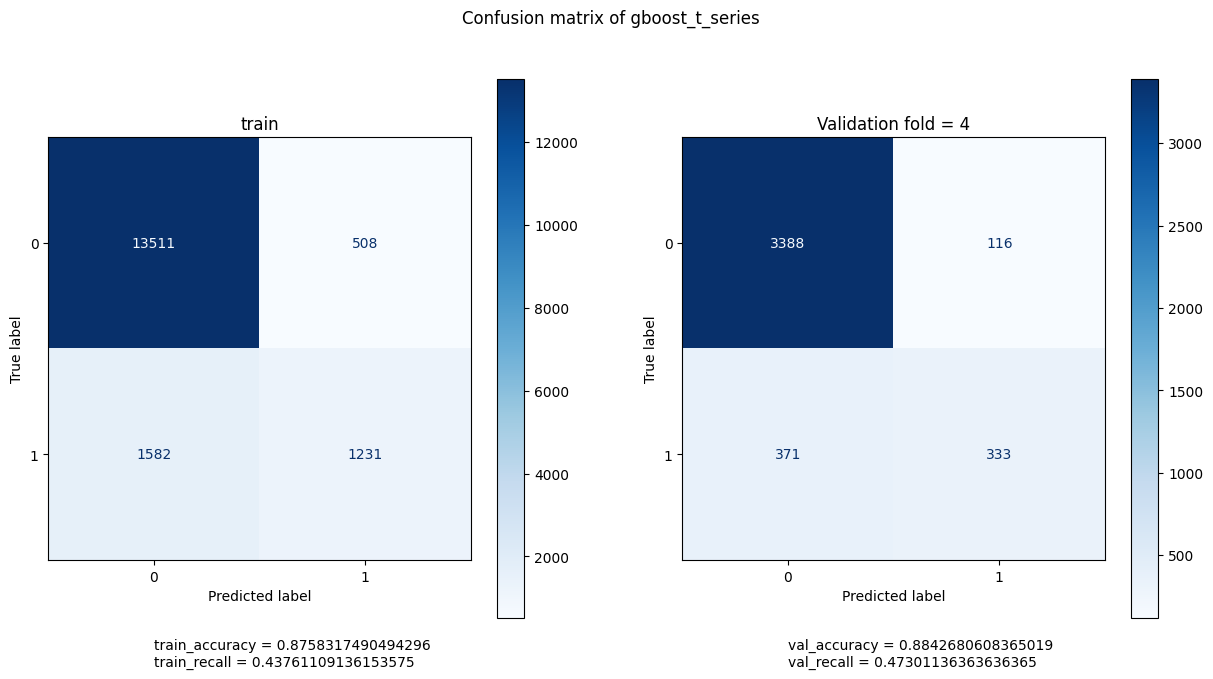

In [21]:
X_train,y_train,X_val,y_val = 0,0,0,0
load_data = load_data_exclude(exclude=True)
best = (0,0,0)
DA_score_df_by_clf = []
for clf in clfs:
        output_path = f'./output/exclude_DIFF_1/{clf}/'
        score_dataframes = []
        for num,(X_train ,y_train, X_val, y_val) in enumerate(load_data.yield_data()):
            pred_val = pd.read_csv(output_path+'/aug_3/'+str(num)+'/pred_val.csv',index_col=0)
            score_val = pd.read_csv(output_path+'/aug_3/'+str(num)+'/score_val.csv',index_col=0)
            scores =pd.Series([clf[3:]]+my_score(y_val,pred_val)+[round(roc_auc_score(y_val,score_val),4)]
                                ,index=['clf','acc','prec','rec','f1','roc_auc'])
            score_dataframes.append(scores)

        evals_frame = pd.concat(score_dataframes, axis=1).transpose()
        DA_score_df_by_clf.append(evals_frame)
NDA_score_df_by_clf = []
for clf in clfs:
        output_path = f'./output/exclude_DIFF_1/{clf}/'
        score_dataframes = []
        for num,(X_train ,y_train, X_val, y_val) in enumerate(load_data.yield_data()):
            pred_train = pd.read_csv(output_path+'/non_aug/'+str(num)+'/pred_train.csv',index_col=0)
            pred_val = pd.read_csv(output_path+'/non_aug/'+str(num)+'/pred_val.csv',index_col=0)
            score_val = pd.read_csv(output_path+'/non_aug/'+str(num)+'/score_val.csv',index_col=0)
            scores =pd.Series([clf[3:]]+my_score(y_val,pred_val)+[round(roc_auc_score(y_val,score_val),4)]
                                ,index=['clf','acc','prec','rec','f1','roc_auc'])
            score_dataframes.append(scores)
            acc = accuracy_score(y_val,pred_val)
            if best[2]<acc:
                best = [clf,num,acc,pred_val,score_val,y_val,y_train,pred_train]
        evals_frame = pd.concat(score_dataframes, axis=1).transpose()
        NDA_score_df_by_clf.append(evals_frame)


best = dict(zip(['clf','num','acc','pred_val','score_val','y_val','y_train','pred_train'],best))

for i in range(4):
    df1 = DA_score_df_by_clf[i]
    df2 = NDA_score_df_by_clf[i]
    df1_styler = df1.style.set_table_attributes("style='display:inline'").set_caption('Data Augmented')
    df2_styler = df2.style.set_table_attributes("style='display:inline'").set_caption('Original')
    display_html(df1_styler._repr_html_()+'\xa0'*8+df2_styler._repr_html_(), raw=True)
    print('\n\n\n')

cf_matrix_t = confusion_matrix(best['y_train'],best['pred_train'])
cf_matrix_v = confusion_matrix(best['y_val'],best['pred_val'])
fig,axes = plt.subplots(1,2,figsize=(15,7))
display = ConfusionMatrixDisplay(cf_matrix_t)
display.plot(cmap=plt.cm.Blues,ax=axes[0])
axes[0].set_title("train")
train_acc = accuracy_score(best['y_train'],best['pred_train'])
train_rec = recall_score(best['y_train'],best['pred_train'])
axes[0].text(0,2,f'train_accuracy = {train_acc}\ntrain_recall = {train_rec}')
display = ConfusionMatrixDisplay(cf_matrix_v)
display.plot(cmap=plt.cm.Blues,ax=axes[1])
axes[1].set_title(f"Validation fold = {best['num']}")
val_acc =accuracy_score(best['y_val'],best['pred_val'])
val_rec = recall_score(best['y_val'],best['pred_val'])
axes[1].text(0,2,f'val_accuracy = {val_acc}\nval_recall = {val_rec}')
name_best = best['clf'][3:]
fig.suptitle(f'Confusion matrix of {name_best}')
plt.show()
plt.close()




In [22]:
clf_names =pd.concat(DA_score_df_by_clf,axis=0).clf
DA_acc_rec =pd.concat(DA_score_df_by_clf,axis=0)[['acc','rec']]
NDA_acc_rec =pd.concat(NDA_score_df_by_clf,axis=0)[['acc','rec']]
df3 =pd.concat( [clf_names,(DA_acc_rec-NDA_acc_rec)*100] , axis=1)
df3.rename(columns={'acc':'Diff on acc','rec':'Diff on rec'})

,clf,Diff on acc,Diff on rec
0,lgbm_t_series,-0.59,2.28
1,lgbm_t_series,-0.4,1.43
2,lgbm_t_series,-0.43,1.7
3,lgbm_t_series,-0.73,0.14
4,lgbm_t_series,-0.76,2.13
0,ADA_t_series,-0.55,2.13
1,ADA_t_series,0.12,2.13
2,ADA_t_series,-0.14,2.27
3,ADA_t_series,-0.07,1.28
4,ADA_t_series,0.07,2.28


## Comparison with non excluded case

In [23]:
load_data = load_data_default()
Original_NDA= []
for clf in clfs:
    if 'gboost' not in clf:
        output_path = f'./output/{clf}/'
        score_dataframes = []
        for num,(X_train ,y_train, X_val, y_val) in enumerate(load_data.yield_data()):
            pred_val = pd.read_csv(output_path+'/non_aug/'+str(num)+'/pred_val.csv',index_col=0)
            score_val = pd.read_csv(output_path+'/non_aug/'+str(num)+'/score_val.csv',index_col=0)
            scores =pd.Series([clf[3:]]+my_score(y_val,pred_val)+[round(roc_auc_score(y_val,score_val),4)]
                                ,index=['clf','acc','prec','rec','f1','roc_auc'])
            score_dataframes.append(scores)

        evals_frame = pd.concat(score_dataframes, axis=1).transpose()
        Original_NDA.append(evals_frame)
load_data = load_data_exclude(exclude=True)
Exc_NDA = []
for clf in clfs:
    if 'gboost' not in clf:
        output_path = f'./output/exclude_DIFF_1/{clf}/'
        score_dataframes = []
        for num,(X_train ,y_train, X_val, y_val) in enumerate(load_data.yield_data()):
            pred_train = pd.read_csv(output_path+'/non_aug/'+str(num)+'/pred_train.csv',index_col=0)
            pred_val = pd.read_csv(output_path+'/non_aug/'+str(num)+'/pred_val.csv',index_col=0)
            score_val = pd.read_csv(output_path+'/non_aug/'+str(num)+'/score_val.csv',index_col=0)
            scores =pd.Series([clf[3:]]+my_score(y_val,pred_val)+[round(roc_auc_score(y_val,score_val),4)]
                                ,index=['clf','acc','prec','rec','f1','roc_auc'])
            score_dataframes.append(scores)
            acc = accuracy_score(y_val,pred_val)
        evals_frame = pd.concat(score_dataframes, axis=1).transpose()
        Exc_NDA.append(evals_frame)
clf_names =pd.concat(Exc_NDA,axis=0).clf
Exc_acc_rec =pd.concat(Exc_NDA,axis=0)[['acc','rec']]
Ori_acc_rec =pd.concat(Original_NDA,axis=0)[['acc','rec']]
df3=pd.concat( [clf_names,(Exc_acc_rec-Ori_acc_rec)*100] , axis=1)
df3.rename(columns={'acc':'Diff on acc','rec':'Diff on rec'})

,clf,Diff on acc,Diff on rec
0,lgbm_t_series,4.98,15.05
1,lgbm_t_series,5.72,17.1
2,lgbm_t_series,6.16,18.74
3,lgbm_t_series,4.83,14.6
4,lgbm_t_series,5.29,16.32
0,ADA_t_series,5.4,8.67
1,ADA_t_series,5.34,8.54
2,ADA_t_series,6.2,11.7
3,ADA_t_series,4.8,5.15
4,ADA_t_series,5.56,9.49


In [24]:
compare_number

,Total,Defaults,None defaults,Default ratio,Non default ratio
Original,22500,4977,17523,0.221200,0.778800
Excluded,21040,3517,17523,0.167158,0.832842


In [25]:
compare_number['Non default ratio'].diff().Excluded

0.054042205323193815

## One more analysis: tried fitting only on feature related to DIFF and payment status

,clf,acc,prec,rec,f1,roc_auc
0,lgbm_t_series,0.830600,0.494800,0.672800,0.570200,0.873500
1,lgbm_t_series,0.842200,0.521100,0.684200,0.591600,0.880200
2,lgbm_t_series,0.850800,0.540800,0.707000,0.612800,0.890400
3,lgbm_t_series,0.825600,0.484400,0.663400,0.560000,0.862200
4,lgbm_t_series,0.840800,0.518300,0.683200,0.589500,0.873800
,clf,acc,prec,rec,f1,roc_auc
0,lgbm_t_series,0.872400,0.662100,0.482200,0.558000,0.876100
1,lgbm_t_series,0.874800,0.676000,0.480800,0.561900,0.881000
2,lgbm_t_series,0.877100,0.689800,0.480800,0.566600,0.889600
3,lgbm_t_series,0.864100,0.628400,0.458800,0.530400,0.862300


,clf,acc,prec,rec,f1,roc_auc
0,ADA_t_series,0.824400,0.483000,0.728300,0.580800,0.876500
1,ADA_t_series,0.831500,0.497000,0.712700,0.585600,0.872900
2,ADA_t_series,0.837500,0.509500,0.726900,0.599100,0.884600
3,ADA_t_series,0.816500,0.466100,0.664800,0.548000,0.859900
4,ADA_t_series,0.831300,0.497000,0.707400,0.583800,0.876300
,clf,acc,prec,rec,f1,roc_auc
0,ADA_t_series,0.877600,0.743500,0.408300,0.527100,0.876400
1,ADA_t_series,0.872100,0.704700,0.404000,0.513600,0.873000
2,ADA_t_series,0.880200,0.745700,0.429600,0.545100,0.884600
3,ADA_t_series,0.866200,0.674100,0.387800,0.492300,0.859200


,clf,acc,prec,rec,f1,roc_auc
0,rf_t_series,0.839400,0.514600,0.677100,0.584800,0.880600
1,rf_t_series,0.844300,0.525800,0.695600,0.598900,0.876600
2,rf_t_series,0.852400,0.545100,0.705500,0.615000,0.891100
3,rf_t_series,0.827500,0.488200,0.647700,0.556800,0.861500
4,rf_t_series,0.844800,0.528300,0.676100,0.593100,0.877500
,clf,acc,prec,rec,f1,roc_auc
0,rf_t_series,0.877400,0.692800,0.478000,0.565700,0.880100
1,rf_t_series,0.871900,0.670800,0.458000,0.544400,0.876100
2,rf_t_series,0.879500,0.700800,0.486500,0.574300,0.890300
3,rf_t_series,0.866400,0.642000,0.456000,0.533200,0.860700


,clf,acc,prec,rec,f1,roc_auc
0,gboost_t_series,0.830300,0.494600,0.715500,0.584900,0.882600
1,gboost_t_series,0.832500,0.499000,0.719800,0.589400,0.879200
2,gboost_t_series,0.839400,0.513600,0.726900,0.601900,0.888900
3,gboost_t_series,0.815400,0.464000,0.669000,0.548000,0.862900
4,gboost_t_series,0.833200,0.501000,0.708800,0.587100,0.877700
,clf,acc,prec,rec,f1,roc_auc
0,gboost_t_series,0.876900,0.736600,0.409700,0.526500,0.881800
1,gboost_t_series,0.872600,0.704200,0.409700,0.518000,0.876000
2,gboost_t_series,0.879000,0.733200,0.433900,0.545100,0.889400
3,gboost_t_series,0.867900,0.669700,0.414800,0.512300,0.860400


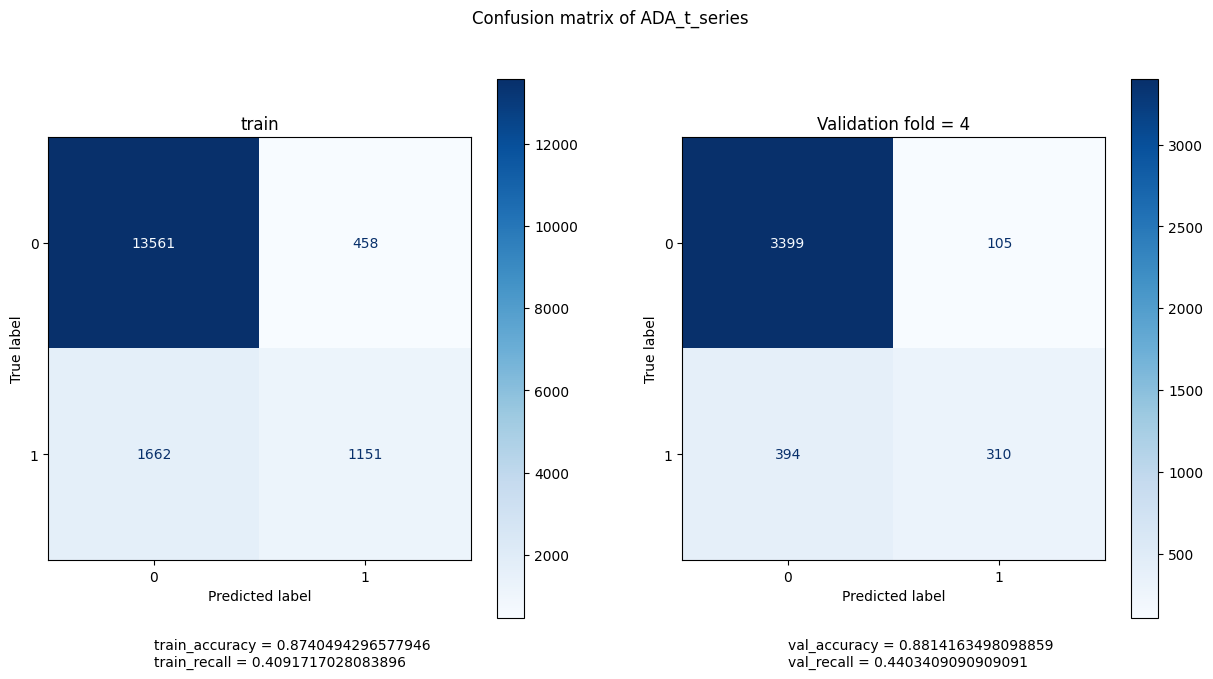

In [26]:
X_train,y_train,X_val,y_val = 0,0,0,0
load_data = load_data_exclude(exclude=True)
best = (0,0,0)
DA_score_df_by_clf = []
for clf in clfs:
        output_path = f'./output/exclude/{clf}/'
        score_dataframes = []
        for num,(X_train ,y_train, X_val, y_val) in enumerate(load_data.yield_data()):
            pred_val = pd.read_csv(output_path+'/aug_3/'+str(num)+'/pred_val.csv',index_col=0)
            score_val = pd.read_csv(output_path+'/aug_3/'+str(num)+'/score_val.csv',index_col=0)
            scores =pd.Series([clf[3:]]+my_score(y_val,pred_val)+[round(roc_auc_score(y_val,score_val),4)]
                                ,index=['clf','acc','prec','rec','f1','roc_auc'])
            score_dataframes.append(scores)

        evals_frame = pd.concat(score_dataframes, axis=1).transpose()
        DA_score_df_by_clf.append(evals_frame)
NDA_score_df_by_clf = []
for clf in clfs:
        output_path = f'./output/exclude/{clf}/'
        score_dataframes = []
        for num,(X_train ,y_train, X_val, y_val) in enumerate(load_data.yield_data()):
            pred_train = pd.read_csv(output_path+'/non_aug/'+str(num)+'/pred_train.csv',index_col=0)
            pred_val = pd.read_csv(output_path+'/non_aug/'+str(num)+'/pred_val.csv',index_col=0)
            score_val = pd.read_csv(output_path+'/non_aug/'+str(num)+'/score_val.csv',index_col=0)
            scores =pd.Series([clf[3:]]+my_score(y_val,pred_val)+[round(roc_auc_score(y_val,score_val),4)]
                                ,index=['clf','acc','prec','rec','f1','roc_auc'])
            score_dataframes.append(scores)
            acc = accuracy_score(y_val,pred_val)
            if best[2]<acc:
                best = [clf,num,acc,pred_val,score_val,y_val,y_train,pred_train]
        evals_frame = pd.concat(score_dataframes, axis=1).transpose()
        NDA_score_df_by_clf.append(evals_frame)


best = dict(zip(['clf','num','acc','pred_val','score_val','y_val','y_train','pred_train'],best))

for i in range(4):
    df1 = DA_score_df_by_clf[i]
    df2 = NDA_score_df_by_clf[i]
    df1_styler = df1.style.set_table_attributes("style='display:inline'").set_caption('Data Augmented')
    df2_styler = df2.style.set_table_attributes("style='display:inline'").set_caption('Original')
    display_html(df1_styler._repr_html_()+'\xa0'*8+df2_styler._repr_html_(), raw=True)
    print('\n\n\n')

cf_matrix_t = confusion_matrix(best['y_train'],best['pred_train'])
cf_matrix_v = confusion_matrix(best['y_val'],best['pred_val'])
fig,axes = plt.subplots(1,2,figsize=(15,7))
display = ConfusionMatrixDisplay(cf_matrix_t)
display.plot(cmap=plt.cm.Blues,ax=axes[0])
axes[0].set_title("train")
train_acc = accuracy_score(best['y_train'],best['pred_train'])
train_rec = recall_score(best['y_train'],best['pred_train'])
axes[0].text(0,2,f'train_accuracy = {train_acc}\ntrain_recall = {train_rec}')
display = ConfusionMatrixDisplay(cf_matrix_v)
display.plot(cmap=plt.cm.Blues,ax=axes[1])
axes[1].set_title(f"Validation fold = {best['num']}")
val_acc =accuracy_score(best['y_val'],best['pred_val'])
val_rec = recall_score(best['y_val'],best['pred_val'])
axes[1].text(0,2,f'val_accuracy = {val_acc}\nval_recall = {val_rec}')
name_best = best['clf'][3:]
fig.suptitle(f'Confusion matrix of {name_best}')
plt.show()
plt.close()




In [27]:
clf_names =pd.concat(DA_score_df_by_clf,axis=0).clf
DA_acc_rec =pd.concat(DA_score_df_by_clf,axis=0)[['acc','rec']]
NDA_acc_rec =pd.concat(NDA_score_df_by_clf,axis=0)[['acc','rec']]
df3 =pd.concat( [clf_names,(DA_acc_rec-NDA_acc_rec)*100] , axis=1)
DA_acc_rec

,acc,rec
0,0.8306,0.6728
1,0.8422,0.6842
2,0.8508,0.707
3,0.8256,0.6634
4,0.8408,0.6832
0,0.8244,0.7283
1,0.8315,0.7127
2,0.8375,0.7269
3,0.8165,0.6648
4,0.8313,0.7074


## Huge increase on recall

In [28]:
df3.rename(columns={'acc':'Diff on acc','rec':'Diff on rec'})

,clf,Diff on acc,Diff on rec
0,lgbm_t_series,-4.18,19.06
1,lgbm_t_series,-3.26,20.34
2,lgbm_t_series,-2.63,22.62
3,lgbm_t_series,-3.85,20.46
4,lgbm_t_series,-3.47,19.88
0,ADA_t_series,-5.32,32.0
1,ADA_t_series,-4.06,30.87
2,ADA_t_series,-4.27,29.73
3,ADA_t_series,-4.97,27.7
4,ADA_t_series,-5.01,26.71


In [29]:
load_data = load_data_default()
Original_NDA= []
for clf in clfs:
    if 'gboost' not in clf:
        output_path = f'./output/{clf}/'
        score_dataframes = []
        for num,(X_train ,y_train, X_val, y_val) in enumerate(load_data.yield_data()):
            pred_val = pd.read_csv(output_path+'/aug_3/'+str(num)+'/pred_val.csv',index_col=0)
            score_val = pd.read_csv(output_path+'/aug_3/'+str(num)+'/score_val.csv',index_col=0)
            scores =pd.Series([clf[3:]]+my_score(y_val,pred_val)+[round(roc_auc_score(y_val,score_val),4)]
                                ,index=['clf','acc','prec','rec','f1','roc_auc'])
            score_dataframes.append(scores)

        evals_frame = pd.concat(score_dataframes, axis=1).transpose()
        Original_NDA.append(evals_frame)
load_data = load_data_exclude(exclude=True)
Exc_NDA = []
for clf in clfs:
    if 'gboost' not in clf:
        output_path = f'./output/exclude/{clf}/'
        score_dataframes = []
        for num,(X_train ,y_train, X_val, y_val) in enumerate(load_data.yield_data()):
            pred_val = pd.read_csv(output_path+'/aug_3/'+str(num)+'/pred_val.csv',index_col=0)
            score_val = pd.read_csv(output_path+'/aug_3/'+str(num)+'/score_val.csv',index_col=0)
            scores =pd.Series([clf[3:]]+my_score(y_val,pred_val)+[round(roc_auc_score(y_val,score_val),4)]
                                ,index=['clf','acc','prec','rec','f1','roc_auc'])
            score_dataframes.append(scores)
            acc = accuracy_score(y_val,pred_val)
        evals_frame = pd.concat(score_dataframes, axis=1).transpose()
        Exc_NDA.append(evals_frame)
clf_names =pd.concat(Exc_NDA,axis=0).clf
Exc_acc_rec =pd.concat(Exc_NDA,axis=0)[['acc','rec']]
Ori_acc_rec =pd.concat(Original_NDA,axis=0)[['acc','rec']]
df3=pd.concat( [clf_names,(Exc_acc_rec-Ori_acc_rec)*100] , axis=1)
df3.rename(columns={'acc':'Diff on acc','rec':'Diff on rec'})

,clf,Diff on acc,Diff on rec
0,lgbm_t_series,3.75,20.75
1,lgbm_t_series,5.09,22.49
2,lgbm_t_series,5.64,25.78
3,lgbm_t_series,3.83,18.55
4,lgbm_t_series,3.59,21.13
0,ADA_t_series,4.15,20.97
1,ADA_t_series,3.91,27.05
2,ADA_t_series,5.75,24.05
3,ADA_t_series,3.67,14.27
4,ADA_t_series,3.04,25.36


## Huge increase in effect of DA on recall

In [30]:
compare_number

,Total,Defaults,None defaults,Default ratio,Non default ratio
Original,22500,4977,17523,0.221200,0.778800
Excluded,21040,3517,17523,0.167158,0.832842


In [31]:
compare_number['Non default ratio'].diff().Excluded

0.054042205323193815

## Note that increase of ratio of non default by excluding bad default sample could have affected the increase in accuracy.

## But still huge increase on recall is noteworhty